In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import sys

import mlflow
import numpy as np
import scanpy as sc
import squidpy as sq

from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import download_nichenet_ligand_target_mx
from autotalker.utils import extract_gps_from_ligand_target_mx
from autotalker.utils import mask_adata_with_gp_dict

In [3]:
dataset = "squidpy_seqfish"
n_epochs = 2
lr = 0.01
batch_size = 64
n_hidden_encoder = 32
n_latent = 16
dropout_rate = 0.

In [4]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv("datasets/seqFISH/counts.csv",
                                        "datasets/seqFISH/adj.csv")
    cell_type_key = None
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius = 0.04, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius = 30.0, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"

Using dataset squidpy_seqfish.


In [5]:
print(f"Number of nodes: {adata.X.shape[0]}")
print(f"Number of node features: {adata.X.shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 4.4
Number of edges: 42694


In [6]:
os.makedirs("mlruns", exist_ok=True)

In [7]:
experiment = mlflow.set_experiment("autotalker")
mlflow.log_param("dataset", dataset)

2022/08/31 09:39:05 INFO mlflow.tracking.fluent: Experiment with name 'autotalker' does not exist. Creating a new experiment.


In [8]:
# Mask that allows all genes
mask = np.ones((n_latent, len(adata.var)))

In [9]:
model = Autotalker(adata,
                   autotalker_module="VGPGAE",
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=dropout_rate,
                   dropout_rate_graph_decoder=dropout_rate,
                   gp_mask=mask)

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
GCN ENCODER -> n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 16, n_output: 351


In [10]:
model.train(n_epochs=n_epochs,
            lr=lr,
            mlflow_experiment_id=experiment.experiment_id)

 |████████████████████| 100.0%  - train_loss: 274.6130588693 - train_edge_recon_loss: 0.8638201153 - train_kl_loss: 0.0206001772 - train_gene_expr_recon_loss: 273.7286388236 - val_loss: 276.1343594719 - val_edge_recon_loss: 0.6398683383 - val_kl_loss: 0.0212318131 - val_gene_expr_recon_loss: 275.4732621137 - val_auroc_score: 0.8849622185 - val_auprc_score: 0.8573845652 - val_best_acc_score: 0.8298074959 - val_best_f1_score: 0.84947138059
Model training finished after 0 min 24 sec.
Saving best model state, which was in epoch 1.
--- MODEL EVALUATION ---
Average test AUROC score: 0.9351855154744092
Average test AUPRC score: 0.903173565372468
Average test best acc score: 0.8793604651162791
Average test best f1 score: 0.9010098575805168


In [11]:
model.save(dir_path="./model_artefacts",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [12]:
model = Autotalker.load(dir_path="./model_artefacts",
                        adata=None,
                        adata_file_name="adata.h5ad")

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
GCN ENCODER -> n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 16, n_output: 351


In [13]:
latent = model.get_latent_representation()

In [14]:
latent_new_data = model.get_latent_representation(adata)

In [15]:
adata.obsm["latent_autotalker"] = latent_new_data

## Interoperability with scanpy

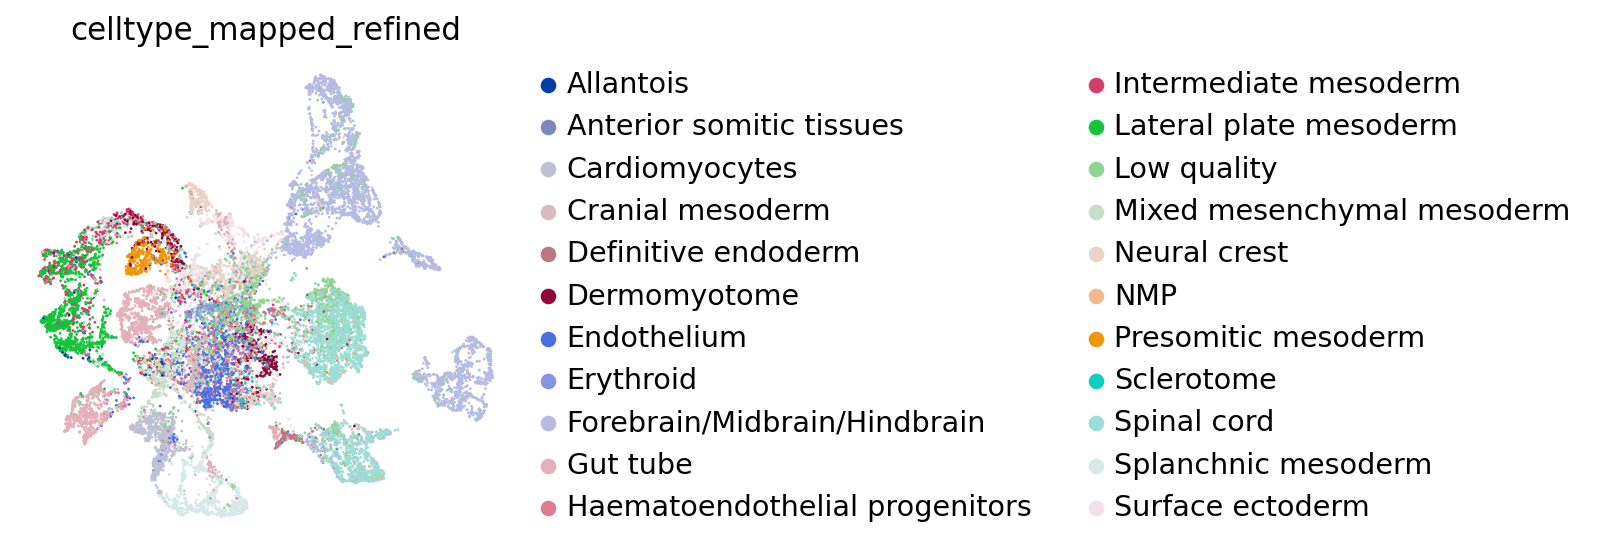

In [30]:
# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=["celltype_mapped_refined"], frameon=False,)

## NicheNet Gene Programs (GPs)

In [ ]:
gp_data_folder_path = "datasets/gp_data"
gp_data_file_path = gp_data_folder_path + "/ligand_target_matrix.csv"
os.makedirs(gp_data_folder_path, exist_ok=True)

In [ ]:
download_nichenet_ligand_target_mx(
    save_path=gp_data_file_path)

In [ ]:
gp_dict = extract_gps_from_ligand_target_mx(
    path=gp_data_file_path)

In [ ]:
mask_adata_with_gp_dict(adata, gp_dict)

In [ ]:
mask = adata.varm["I"].T

In [ ]:
mask.shape

In [ ]:
mask.shape

In [ ]:
I = [[int(gene in gp) for _, gp in gp_dict.items()] for gene in adata_genes]
I = np.asarray(I, dtype="int32")

In [ ]:
gp_dict

In [ ]:
I.sum()

In [ ]:
for gp_name, gp in gp_dict.items():
    print(gp_name)
    print(gp)
    break

## SCVI

In [17]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0


In [18]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [19]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts"
)

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scvi/data/_utils.py:114: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [20]:
model = scvi.model.SCVI(adata)

In [21]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [22]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|███████| 400/400 [06:24<00:00,  1.04it/s, loss=265, v_num=1]


In [23]:
latent = model.get_latent_representation()

In [24]:
adata.obsm["X_scVI"] = latent

In [33]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

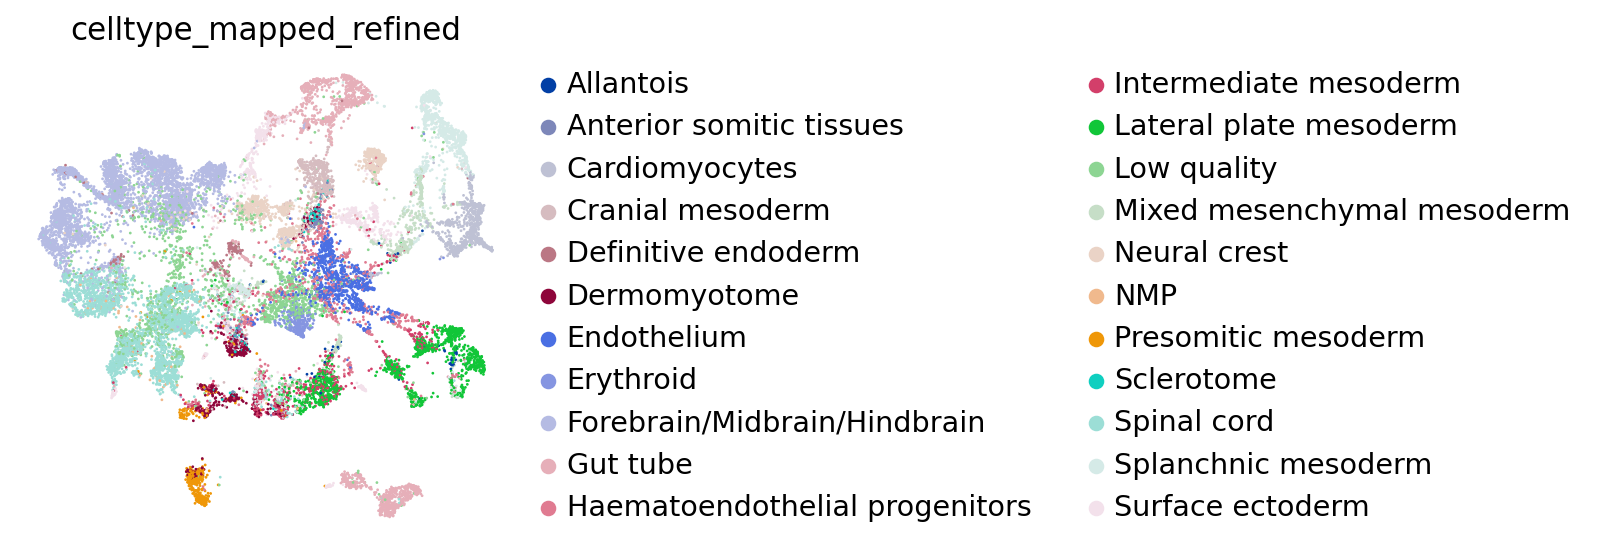

In [34]:
sc.pl.umap(
    adata,
    color=["celltype_mapped_refined"],
    frameon=False,
)